In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#!unzip "/content/drive/Shareddrives/Metehan Çetinkaya - fireDetection/firedataset.zip"    #ilk çalışma haricinde kapalı olması gereken satır

In [ ]:
lst_fire_img = glob.glob('/content/fire_dataset/fire_images/*.png')
lst_non_fire_img = glob.glob('/content/fire_dataset/non_fire_images/*.png')

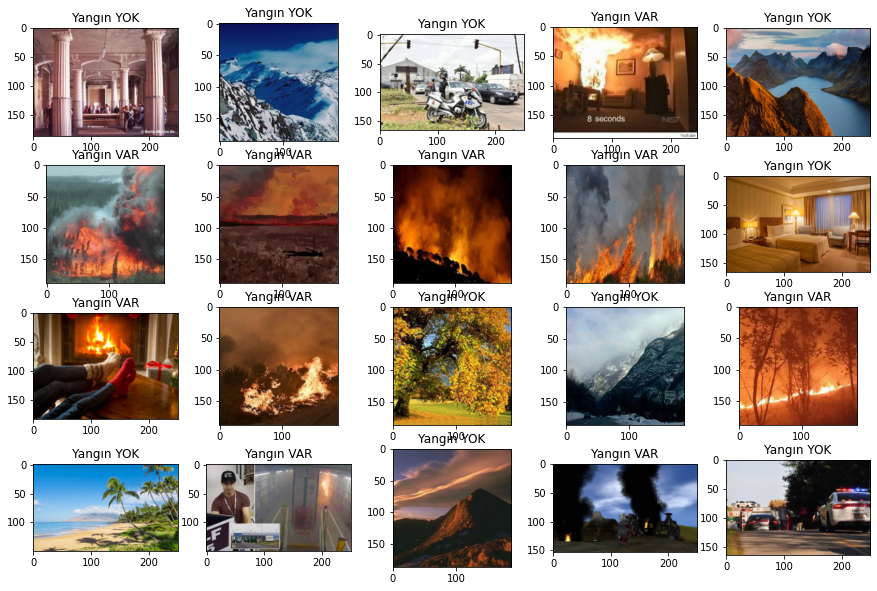

In [ ]:
lst_images_random = random.sample(lst_fire_img,10) + random.sample(lst_non_fire_img,10)
random.shuffle(lst_images_random)

plt.figure(figsize = (15,10))

for i in range(len(lst_images_random)):
    
    plt.subplot(4,5,i+1)

    if "non_fire" in lst_images_random[i]:
        img = cv2.imread(lst_images_random[i])
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        plt.imshow(img,cmap = 'gray')
        plt.title('Yangın YOK')

    else:
        img = cv2.imread(lst_images_random[i])
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        plt.imshow(img,cmap = 'gray')
        plt.title("Yangın VAR")

plt.show()

### Data Framing

In [ ]:
lst_fire = []
for x in lst_fire_img:
  lst_fire.append([x,1])


lst_nn_fire = []
for x in lst_non_fire_img:
  lst_nn_fire.append([x,0])


lst_complete = lst_fire + lst_nn_fire
random.shuffle(lst_complete)

In [ ]:
df = pd.DataFrame(lst_complete,columns = ['files','target'])
df.head(10)

,files,target
0,/content/fire_dataset/fire_images/image_726.png,1
1,/content/fire_dataset/fire_images/fire_0836.png,1
2,/content/fire_dataset/fire_images/18.png,1
3,/content/fire_dataset/fire_images/abc141.png,1
4,/content/fire_dataset/fire_images/fire_0369.png,1
5,/content/fire_dataset/non_fire_images/323.png,0
6,/content/fire_dataset/fire_images/4.png,1
7,/content/fire_dataset/fire_images/fire_0203.png,1
8,/content/fire_dataset/non_fire_images/image_25...,0
9,/content/fire_dataset/non_fire_images/nofire_0...,0


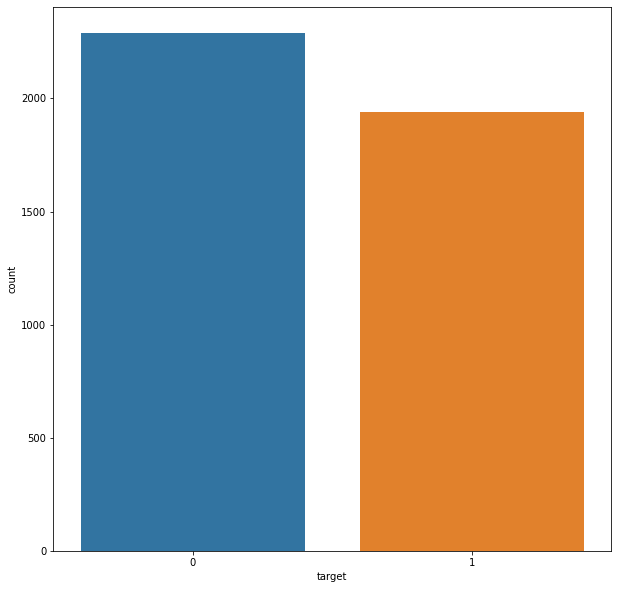

In [ ]:
plt.figure(figsize = (10,10))

sns.countplot(x = "target",data = df)
plt.show()

### Preprocessing Images

In [ ]:
def preprocessing_image(filepath):
  img = cv2.imread(filepath) #read
  img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) #convert
  img = cv2.resize(img,(196,196))  # resize
  img = img / 255 #scale
  return img

In [ ]:
def create_format_dataset(dataframe):
  X = []
  y = []
  for f,t in dataframe.values:
    X.append(preprocessing_image(f))
    y.append(t)
  
  return np.array(X),np.array(y)

In [ ]:
X, y = create_format_dataset(df)

In [ ]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size = 0.3,stratify = y)

In [ ]:
[X_train.shape,y_train.shape],...,[X_valid.shape,y_valid.shape]

([(2960, 196, 196, 3), (2960,)], Ellipsis, [(1269, 196, 196, 3), (1269,)])

### CNN Layers

In [ ]:
model = Sequential()

model.add(Conv2D(128,(2,2),input_shape = (196,196,3),activation='relu'))
model.add(Conv2D(64,(2,2),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32,(2,2),activation='relu'))
model.add(MaxPooling2D())

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1,activation= "sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 195, 195, 128)     1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 194, 194, 64)      32832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 97, 97, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss',patience = 5,restore_best_weights=True)]

model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs = 30,batch_size = 32,callbacks = callbacks)

Epoch 1/30
93/93 [==============================] - 50s 200ms/step - loss: 0.4910 - accuracy: 0.7986 - val_loss: 0.3289 - val_accuracy: 0.8471
Epoch 2/30
93/93 [==============================] - 16s 173ms/step - loss: 0.2908 - accuracy: 0.8811 - val_loss: 1.0745 - val_accuracy: 0.6848
Epoch 3/30
93/93 [==============================] - 16s 173ms/step - loss: 0.2721 - accuracy: 0.8895 - val_loss: 0.2292 - val_accuracy: 0.9133
Epoch 4/30
93/93 [==============================] - 16s 173ms/step - loss: 0.1785 - accuracy: 0.9361 - val_loss: 0.2258 - val_accuracy: 0.9133
Epoch 5/30
93/93 [==============================] - 16s 174ms/step - loss: 0.1653 - accuracy: 0.9372 - val_loss: 0.2936 - val_accuracy: 0.8849
Epoch 6/30
93/93 [==============================] - 16s 174ms/step - loss: 0.1426 - accuracy: 0.9514 - val_loss: 0.2688 - val_accuracy: 0.9046
Epoch 7/30
93/93 [==============================] - 16s 175ms/step - loss: 0.1122 - accuracy: 0.9635 - val_loss: 0.3264 - val_accuracy: 0.9046

In [ ]:
val_loss, val_acc = model.evaluate(X_valid, y_valid)
print('Validation Accuracy: {}'.format(val_acc))

40/40 [==============================] - 2s 39ms/step - loss: 0.2258 - accuracy: 0.9133
Validation Accuracy: 0.9133175611495972



### MODEL OUT

In [ ]:
model.save('/content/drive/Shareddrives/Metehan Çetinkaya - fireDetection/fireModel.h5') 